# Онлайн-магазин
## Общее описание:

Команда внедрила в приложение по доставке продуктов умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

### Задача:
Оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. 


### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Знакомство с данными
    - Предобработка данных
    - Вывод итогового ДФ из имеющихся таблиц и дальнейший анализ
    
    
2. **Далее сформулируем важные метрики для бизнеса:**
    - Сформулируем метрики, которые будем тестировать
    - Определим нулевую и альернативную гипотезы, критический уровень значимости   

3. **Тестируем гипотезы:**
     - Выбираем подходящий тест
     - Тестируем
     
     
4. **Подводим итоги:**

### 1. Выгрузка и изучение имеющихся данных

In [71]:
# Импорт требуемых библиотек

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

from scipy.stats import chi2_contingency, chi2 
import pingouin as pg
import scipy.stats as stats

In [72]:
ab_orders     = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-h-gajzetdinova/Statistics/ab_orders.csv')
ab_products   = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-h-gajzetdinova/Statistics/ab_products.csv')
ab_users_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-h-gajzetdinova/Statistics/ab_users_data.csv')

In [73]:
# Информация о составе заказа

ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [74]:
# Информация о продуктах

ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [75]:
# История заказов пользователей

ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


#### Знакомство с данными


Данные с информацией о составе заказов (датафрейм `ab_orders`):
- `order_id` — идентификатор заказа 
- `creation_time` — время создания заказа  
- `product_ids`— список id продуктов, которые были включены в заказ

Данные с информацией о продуктах (датафрейм `ab_products`):
- `product_id`— идентификатор продуктов
- `name` — наименование продукта
- `price` — стоимость продукта

История заказов пользователей (датафрейм `ab_users_data`):
- `user_id`— идентификатор пользователя
- `order_id` — идентификатор заказа 
- `action`— действие с заказом (create_order или cancel_order)
- `time`— время
- `date` — дата
- `group` — пользователи с новой и старой системой рекомендаций (1 и 0 соответственно)

#### Предобработка данных

In [76]:
# Обзор датафрейма ab_orders

ab_orders.info()

ab_orders.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


0

В таблице ab_orders нет пропусков и дубликатов, но столбец со временем имеет неправильный тип данных

In [77]:
# Корректировка типа данных в столбце 'creation_time'

ab_orders['creation_time'] = pd.to_datetime(ab_orders['creation_time'])
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"


In [78]:
# Обзор датафрейма ab_products

ab_products.info()

ab_products.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


0

В таблице ab_orders нет пропусков и дубликатов, корректрировка не требуется

In [79]:
# Обзор датафрейма ab_users_data

ab_users_data.info()

ab_users_data.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB


0

В таблице ab_users_data нет пропусков и дубликатов, но столбцы со временем имеют неправильный тип данных

In [80]:
# Корректировка типа данных в столбцах 'time' и 'date'

ab_users_data['time'] = pd.to_datetime(ab_users_data['time'])
ab_users_data['date'] = pd.to_datetime(ab_users_data['date'])
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


#### Вывод итогового ДФ из имеющихся таблиц для анализа

Перейдем к `ab_orders` - подготовим датафрейм к объединению с остальными

In [81]:
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"


In [82]:
# Преобразуем каждый элемент множества 'product_ids' в отдельную строку

ab_orders['product_ids'] = ab_orders['product_ids'] \
                        .str.strip('{}') \
                        .str.split(',')
ab_orders =ab_orders.explode('product_ids').reset_index(drop= True)

ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,75
1,1255,2022-08-26 00:00:19,22
2,1255,2022-08-26 00:00:19,53
3,1255,2022-08-26 00:00:19,84
4,1256,2022-08-26 00:02:21,56


In [83]:
# Скорректируем тип полученных значений в колонке 'product_ids' на int64, чтобы далее производить вычисления
# Переименуем колонку 'product_id', чтобы далее объединить таблицы 'df_product' и 'ab_products' по общему ключу

ab_orders['product_ids'] = ab_orders['product_ids'].astype(int)
ab_orders = ab_orders.rename(columns={'product_ids': 'product_id'})

display(ab_orders.dtypes)
display(ab_orders.shape)

order_id                  int64
creation_time    datetime64[ns]
product_id                int64
dtype: object

(13826, 3)

In [84]:
# Оъединим полученный дф с таблицей о продуктах

df_orders = ab_orders.merge(ab_products, how='left', on = 'product_id')
df_orders.head()

,order_id,creation_time,product_id,name,price
0,1255,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,1255,2022-08-26 00:00:19,22,сок мультифрукт,120.0
2,1255,2022-08-26 00:00:19,53,мука,78.3
3,1255,2022-08-26 00:00:19,84,мандарины,90.4
4,1256,2022-08-26 00:02:21,56,сосиски,150.0


In [85]:
# Выведем стоимость каждого заказа

price_order = df_orders.groupby('order_id', as_index=False) \
                        .agg({'price': 'sum'}) \
                        .rename(columns={'price':'price_order'})
price_order.head()

,order_id,price_order
0,1255,408.7
1,1256,250.5
2,1257,310.2
3,1258,85.0
4,1259,228.0


In [86]:
# Оъединим дф и получим информацию по каждому заказу

df_orders_price = df_orders.merge(price_order, how= 'inner', on='order_id')

df_orders_price.head()

,order_id,creation_time,product_id,name,price,price_order
0,1255,2022-08-26 00:00:19,75,сок ананасовый,120.0,408.7
1,1255,2022-08-26 00:00:19,22,сок мультифрукт,120.0,408.7
2,1255,2022-08-26 00:00:19,53,мука,78.3,408.7
3,1255,2022-08-26 00:00:19,84,мандарины,90.4,408.7
4,1256,2022-08-26 00:02:21,56,сосиски,150.0,250.5


In [87]:
# Оставим только необходимые колонки, удалим дубли

df_orders_price = df_orders_price[['order_id', 'price_order', 'creation_time']].drop_duplicates()
display(df_orders_price.head())
display(df_orders_price.shape)

,order_id,price_order,creation_time
0,1255,408.7,2022-08-26 00:00:19
4,1256,250.5,2022-08-26 00:02:21
7,1257,310.2,2022-08-26 00:02:27
11,1258,85.0,2022-08-26 00:02:56
13,1259,228.0,2022-08-26 00:03:37


(4123, 3)

In [88]:
# Выведем таблицу с заказами пользователей и информацией по тестированию

display(ab_users_data.head())
display(ab_users_data.shape)

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


(4337, 6)

Таблица 'ab_users_data' содержит в себе больше строк по сравнению с таблицей со стоимостью 'order_id', это связано с тем, что пользователи могли также отменить ранее созданный заказ. Объединим эти две таблицы и проконтролиуем, чтобы не потерять позиции с отменами

In [89]:
# Объединение итоговых таблиц

df_ab = ab_users_data.merge(df_orders_price, how='left', on = 'order_id')
display(df_ab.head())
display(df_ab.shape)

,user_id,order_id,action,time,date,group,price_order,creation_time
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,408.7,2022-08-26 00:00:19
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,250.5,2022-08-26 00:02:21
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,310.2,2022-08-26 00:02:27
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,85.0,2022-08-26 00:02:56
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,228.0,2022-08-26 00:03:37


(4337, 8)

In [90]:
# Подсчет количества уникальных пользователей в каждой группе

df_ab.groupby('group', as_index=False).user_id.nunique()

,group,user_id
0,0,515
1,1,502


Всего в эксперименте участвовало 1017 пользоdателей, в контрольной группе участие приняли на 13 пользователей больше, чем в экспериментальной.

Посмотрим как вели себя поьзователи в зависимости от групп: как изменилось количествво заказов и отмен в магазине.

In [91]:
# Подготовим таблицу сопряженности

pd.crosstab(df_ab.group, df_ab.action)

action,cancel_order,create_order
group,,
0,82,1609
1,132,2514


Полученные результаты показывают:
- пользователи экспериментальной группы однозначно оформляют большее количество заказаов
- также увеличилось и количество отмен в интернет магазине с внедрением новой фичи.

Полученные данные не позволяют однозначно утверждать об эффективности внедренных изменений, для формирования вывода необходимо исследовать большее количество метрик.

Дальнейшая работа будет происходить с таблицей , которая включает в себя только созданные заказы без отмен. Т.к. если пользователь отменил заказ, оплата за него также возвращается, что влияет на показатели выручки среднего чека и т.д.
Подготовим такую таблицу для работы.

In [92]:
# Формируем список отмененных айди заказов

df_cancel_order = df_ab.query('action == "cancel_order"')
df_cancel_order.head()

,user_id,order_id,action,time,date,group,price_order,creation_time
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,85.0,2022-08-26 00:02:56
39,993,1296,cancel_order,2022-08-26 00:44:18.150475,2022-08-26,0,535.8,2022-08-26 00:39:26
47,995,1298,cancel_order,2022-08-26 00:49:51.514240,2022-08-26,0,273.8,2022-08-26 00:43:47
54,1002,1308,cancel_order,2022-08-26 00:58:01.924112,2022-08-26,1,1025.0,2022-08-26 00:51:54
60,1008,1315,cancel_order,2022-08-26 01:06:11.292953,2022-08-26,0,190.0,2022-08-26 00:58:59


In [93]:
# Выводим список только созданных заказов (без отмен)

df_create_order = df_ab[~df_ab.loc[:,'order_id'].isin(df_cancel_order['order_id'])]
df_create_order.head()

,user_id,order_id,action,time,date,group,price_order,creation_time
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,408.7,2022-08-26 00:00:19
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,250.5,2022-08-26 00:02:21
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,310.2,2022-08-26 00:02:27
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,228.0,2022-08-26 00:03:37
5,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,430.7,2022-08-26 00:05:35


### 2. Формулировка рассматриваемых метрик



1. Изменилось ли поведение пользователей после внедрения новой фичи: стали ли пользователи чаще оформлять заказы?
2. Увеличилась ли накопленная выручка магазина? 
3. Стоимость заказа на пользователя в группах
4. Количество уникальных пользователей и выручка по дням

Перед проведением тестирований определим основную и альтернативную гипотезы и критический уровень статистической значимости:

- Нулевая гипотеза: новый алгоритм не повлиял на количество заказов
- Альтернативная гипотеза: новый алгоритм повлиял на заказы пользователей

Уровень значимости p-value = 0.05

In [29]:
# Убедимся, что участники не попадают одновременно в экспериментальную и контрольную группу

df_ab.groupby('group').user_id.nunique().reset_index().query('group > 1')

,group,user_id


In [30]:
# Датафрейм без отмененных заказов для дальнейшей работы 

df_order = df_create_order.copy()
df_order.head()

,user_id,order_id,action,time,date,group,price_order,creation_time
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,408.7,2022-08-26 00:00:19
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,250.5,2022-08-26 00:02:21
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,310.2,2022-08-26 00:02:27
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,228.0,2022-08-26 00:03:37
5,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,430.7,2022-08-26 00:05:35


### Выбор и тестирование гипотезы
#### 3.1 Пользователи стали чаще оформлять заказы?

Для сравнения количества заказов на пользователя воспользуемся t-критерием, он позволяет сравнить среднее арифметическое двух групп.

Для начала визуально оценим влияние обновленй на увеличение количества заказов на пользователя

In [31]:
# Подсчет количества заказов(без отмен) на пользователя)

create_orders = df_order \
        .groupby(['group', 'user_id'], as_index=False) \
        .order_id.count() \
        .rename(columns={'order_id': 'count_order'})
create_orders.head()

,group,user_id,count_order
0,0,964,2
1,0,968,3
2,0,969,2
3,0,972,1
4,0,975,2


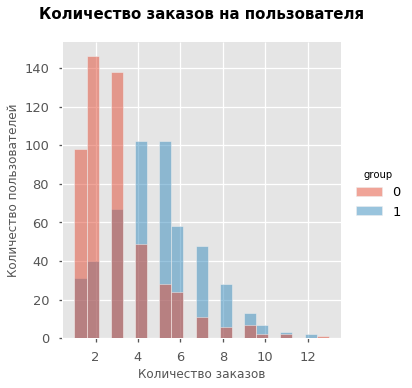

In [97]:
# Графическое представление
plt.style.use('fast')
sns.displot(create_orders, x = 'count_order', hue='group')
plt.ylabel("Количество пользователей")
plt.xlabel("Количество заказов")
plt.title("Количество заказов на пользователя\n", fontsize=15, fontweight = 'bold')
plt.show()

График демонстрирует увеличение числа заказов на пользователя:
    пользователи экпериментальной группы чаще офрмляют заказы

In [33]:
# Проверка статистической значимости с помощью t-test

pg.ttest(x = create_orders.query('group == 0')['count_order'], y = create_orders.query('group == 1')['count_order'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-13.97417,989.822835,two-sided,1.237410e-40,"[-2.02, -1.52]",0.879358,1.801e+37,1.0


#### 3.2 Увеличилась ли накопленная выручка магазина?

Для проверки воспользуемся Критерием Хи-квадрат, тк проверяется взаимосвязь между категориальными переменными. 

In [34]:
# Создание столбца 'revenue' с информацией по накопленной выручке по группам за весь период
# Вывод требуемых колонок для анализа

df_order['revenue'] = df_order.groupby('group').price_order.cumsum()
revenue = df_order[['date', 'group', 'revenue']]
revenue.head()

,date,group,revenue
0,2022-08-26,0,408.7
1,2022-08-26,1,250.5
2,2022-08-26,0,718.9
4,2022-08-26,1,478.5
5,2022-08-26,0,1149.6


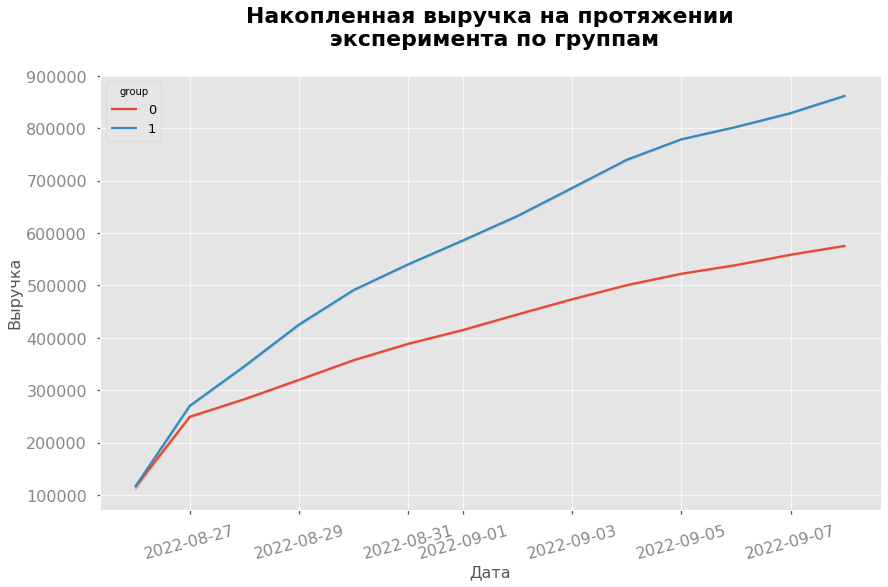

In [65]:
plt.figure(figsize=(14,8))
plt.style.use('fast')
ax = sns.lineplot(data=revenue, x = 'date', y='revenue', hue = 'group')

plt.xticks(rotation=15, fontsize=16, alpha=.7)
plt.yticks(fontsize=16, alpha=.7)
plt.title("Накопленная выручка на протяжении\n эксперимента по группам\n", fontsize=22, fontweight = 'bold')
plt.xlabel("Дата", fontsize=16)
plt.ylabel("Выручка", fontsize=16)
plt.grid(axis='both', alpha=.7)

plt.show()

In [36]:
# Численные данные итоговой выручки в зависимости от группы

df_order.groupby('group', as_index=False)\
        .price_order.sum()\
        .rename(columns={'price_order': 'all_revenue'})

,group,all_revenue
0,0,583455.9
1,1,878628.4


По графику и полученным табличным данным явно видно, что выручка в экспериментальной группе превысила значение контрольной. На первый взгляд, новое внедрение положительно сказывается на работе магазина: растет накопленная выручка в экспериментальной группе, пользователи с новой версией приложения оформляют заказы дороже, чем пользователи со старой версией. 


#### 3.3 Увеличилилась ли стоимость заказа с ведрением нового алгоритма?

In [37]:
# Нахождение стоимости заказа для каждого пользователя по группам

daily_revenue = df_order\
                    .groupby(['user_id', 'date', 'group'], as_index=False)\
                    .agg({'price_order':'sum', 'order_id':'count'})\
                    .rename(columns={'price_order': 'revenue_user', 'order_id': 'count_orders'})
daily_revenue['average_check'] = round(daily_revenue.revenue_user/daily_revenue.count_orders,2)

daily_revenue.head()

,user_id,date,group,revenue_user,count_orders,average_check
0,964,2022-08-26,0,718.9,2,359.45
1,965,2022-08-26,1,250.5,1,250.50
2,965,2022-08-27,1,860.6,1,860.60
3,965,2022-08-29,1,1845.8,4,461.45
4,965,2022-09-04,1,1198.6,3,399.53


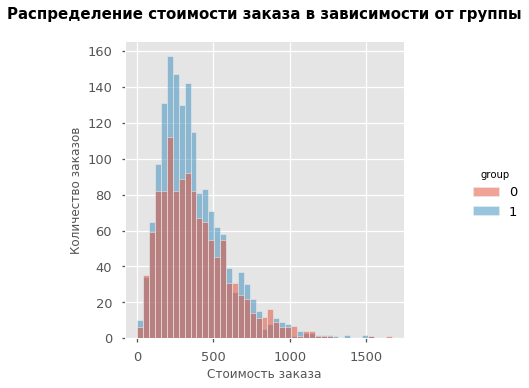

In [66]:
# Визуальное представление распределения стоимости заказов на пользователя
plt.style.use('fast')
sns.displot(daily_revenue, x='average_check', hue='group')
plt.ylabel("Количество заказов")
plt.xlabel("Стоимость заказа")
plt.title("Распределение стоимости заказа в зависимости от группы\n", fontsize=15, fontweight = 'bold')

plt.show()

Визуально видно, что средний чек пользователей, которые пользуются новой версией приожения, выше, чем пользователей со старой версией. Проверим являются ли полученные различия статистически значимыми или получились случайно.

In [41]:
# Проверка на нормальность показателя среднего чека

pg.normality(data=daily_revenue, dv="average_check", group="group", method='normaltest')

,W,pval,normal
0,226.089986,8.038653e-50,False
1,406.414702,5.599752e-89,False


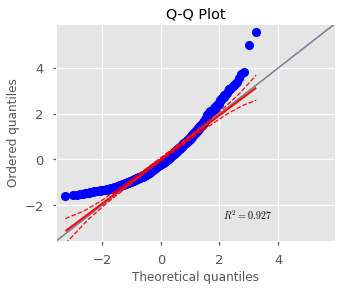

In [67]:
# Дополнительная проверка на нормальность с помощью Q-Q Plot
plt.style.use('fast')
pg.qqplot(daily_revenue.query('group==0').average_check)
plt.show()

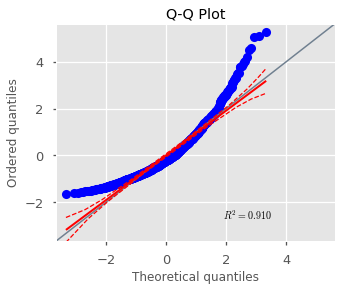

In [68]:
plt.style.use('fast')
pg.qqplot(daily_revenue.query('group==1').average_check)
plt.show()

Согласно тесту на нормальность и графикам Q-Q Plots, средний чек распределен ненормально, применим непараметрический аналог двустороннего независимого t-теста - тест Манна-Уитни

In [44]:
stats.mannwhitneyu(x = daily_revenue.query('group == 0').average_check,\
                   y = daily_revenue.query('group == 1').average_check)

MannwhitneyuResult(statistic=1004134.0, pvalue=0.2324078354223157)

P-value значительно больше 0.05. 
Значит, причин отвергать нулевую гипотезу нет. 
Средний чек контрольной группы показал себя выше среднего чека экспериментальной группы.

Наблюдаемые различия не являются значимыми при таком уровне значимости, а следовательно могли быть получены случайно.
Перейдем к следующим метрикам.

#### 3.4 Количество уникальных пользователей и выручка по дням

In [45]:
# Вывод ежедневной выручки и количества уникальных пользователей в день по группам 

df_ab_test = df_order \
            .groupby(['date', 'group'], as_index=False) \
            .agg({'price_order':'sum', 'user_id': 'nunique'}) \
            .rename(columns={'price_order':'daily_revenue', 'user_id': 'count_user_unique'})
df_ab_test.head()

,date,group,daily_revenue,count_user_unique
0,2022-08-26,0,228375.1,496
1,2022-08-26,1,235186.6,487
2,2022-08-27,0,39458.8,81
3,2022-08-27,1,70903.0,129
4,2022-08-28,0,31033.2,70


In [46]:
# Посмотрим на описательную статистику полученных метрик

df_ab_test[['daily_revenue', 'count_user_unique']].describe()

,daily_revenue,count_user_unique
count,28.000000,28.000000
mean,52217.296429,100.964286
std,53707.536413,113.635050
min,14450.600000,34.000000
25%,26309.725000,51.750000
50%,34219.950000,71.500000
75%,52108.250000,86.500000
max,235186.600000,496.000000


Выявлены экстремально высокие показания: среднее сформированных метрик сильно отклоняется от медианного, построим графики для каждой из метрик, чтобы понять причину таких значений

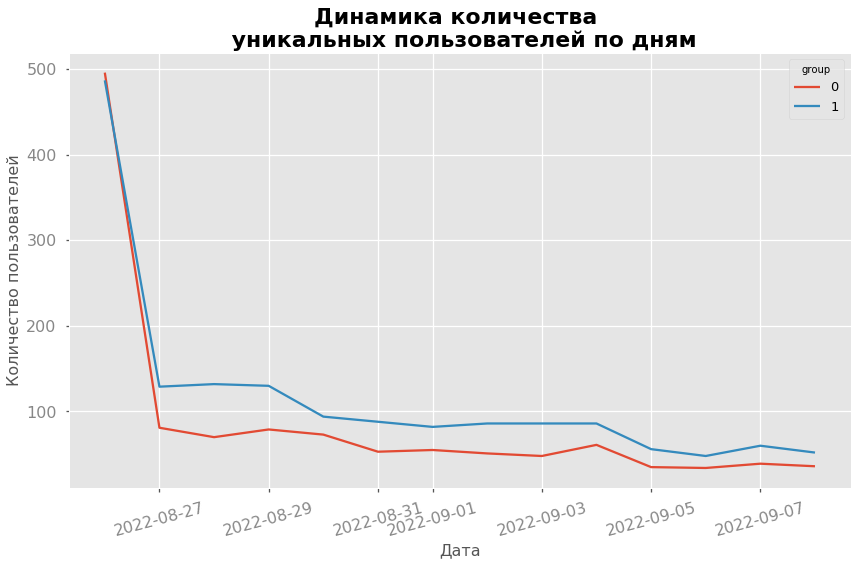

In [69]:
plt.figure(figsize=(14,8))
plt.style.use('fast')

ax = sns.lineplot(data=df_ab_test, x = 'date', y='count_user_unique', hue = 'group')
plt.xticks(rotation=15, fontsize=16, alpha=.7)
plt.yticks(fontsize=16, alpha=.7)
plt.title("Динамика количества \n уникальных пользователей по дням", fontsize=22, fontweight = 'bold')
plt.xlabel("Дата", fontsize=16)
plt.ylabel("Количество пользователей", fontsize=16)


plt.show()

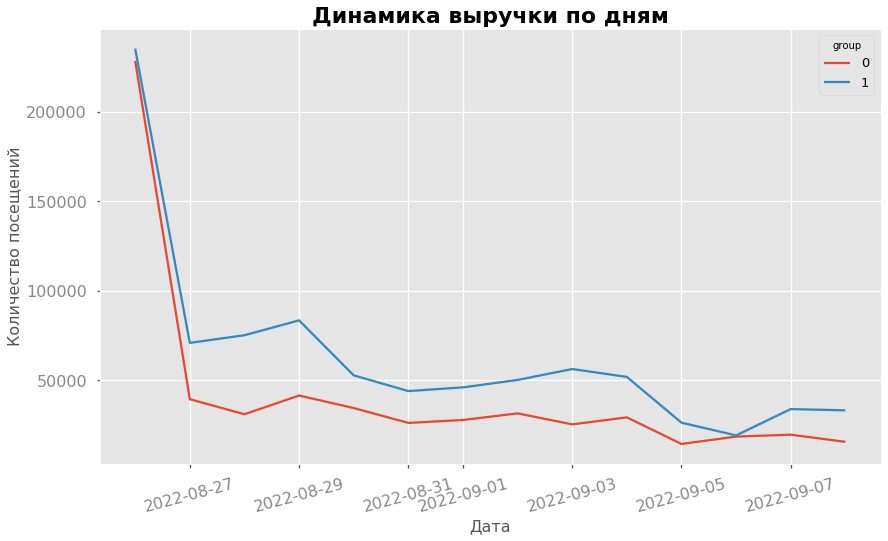

In [70]:
plt.figure(figsize=(14,8))
plt.style.use('fast')

ax = sns.lineplot(data=df_ab_test, x = 'date', y='daily_revenue', hue = 'group')
plt.xticks(rotation=15, fontsize=16, alpha=.7)
plt.yticks(fontsize=16, alpha=.7)
plt.title("Динамика выручки по дням", fontsize=22, fontweight = 'bold')
plt.xlabel("Дата", fontsize=16)
plt.ylabel("Количество посещений", fontsize=16)

plt.show()

Визуально можно определить, что экспериментальная группа показала себя лучше контрольной: 
выручка и количество пользователей в день больше в течение всего эксперимента. 

Аномально высокие значения обнаружены в первый день тестирования: показатели по всем параметрам практически в 5 раз выше чем в остальные дни. Возможно, в указанную дату проводились какие-либо акции в магазине, также возможен сбой системы и данные записались с ошибкой. 

Нельзя однозначно считать показатели, полученные 26 августа багом, поэтому 
посчитаем статистическую значимость различий метрик по «сырым» данным — без удаления аномальных пользователей и по "очищенным", удалив показатели первого дня эксперимента из расчетов. И после сделаем выводы по успешности проведенного АВ тестирования.

##### Статистическая значимость ежедневной выручки и количества уникальных пользователей  в день по "сырым" данным:

In [191]:
# Проверка на нормальность показателя выручки

pg.normality(data=df_ab_test, dv="daily_revenue", group="group", method='shapiro')

,W,pval,normal
0,0.438983,0.000002,False
1,0.630245,0.000076,False


In [192]:
# Проверка на нормальность количества пользователей

pg.normality(data=df_ab_test, dv="count_user_unique", group="group", method='shapiro')

,W,pval,normal
0,0.420210,0.000001,False
1,0.526888,0.000010,False


Все из рассматриваемых метрик показали себя ненормально, применим тест Манна-Уитни для проверки статистической значимости.

In [193]:
# Тест Манна-Уитни для показателя ежедневной выручки

stats.mannwhitneyu(x = df_ab_test.query('group == 0').daily_revenue,\
                    y = df_ab_test.query('group == 1').daily_revenue)

MannwhitneyuResult(statistic=36.0, pvalue=0.004716530360235347)

In [194]:
# Тест Манна-Уитни для количества пользователей по дням

stats.mannwhitneyu(x = df_ab_test.query('group == 0').count_user_unique,\
                    y = df_ab_test.query('group == 1').count_user_unique)

MannwhitneyuResult(statistic=39.5, pvalue=0.007657936057003459)

P-value меньше 0.05, поэтому нулевую гипотезу отвергаем.
Анализ «сырых данных» сообщает, что в ежедневной выручке и количестве пользователей есть статистически значимые различия. Осталось сравнить метрики ещё раз после удаления выбросов.

##### Статистическая значимость ежедневной выручки и количества уникальных пользователей в день по "очищенным" данным:

In [195]:
# Удалили из дф первый "аномальный" день тестирования

df_ab_test_clean = df_ab_test.query('date != "2022-08-26"')
df_ab_test_clean.head()

,date,group,daily_revenue,count_user_unique
2,2022-08-27,0,39458.8,81
3,2022-08-27,1,70903.0,129
4,2022-08-28,0,31033.2,70
5,2022-08-28,1,75167.7,132
6,2022-08-29,0,41496.3,79


In [196]:
# Проверка на нормальность показателя выручки

pg.normality(data=df_ab_test_clean, dv="daily_revenue", group="group", method='shapiro')

,W,pval,normal
0,0.962400,0.790238,True
1,0.969591,0.889351,True


In [197]:
# Проверка на нормальность количества пользователей

pg.normality(data=df_ab_test_clean, dv="count_user_unique", group="group", method='shapiro')

,W,pval,normal
0,0.921476,0.262607,True
1,0.889153,0.094984,True


После удаления аномальных значений, полученных 26 августа, распределение рассматриваемых метрик демонстрирует нормальное распределение.
Применим Т-тест для проверки статистической значимости. Придерживаемся ранее установленным гипотезам и уровню значимости.

In [198]:
# t-тест для показателя ежедневной выручки

pg.ttest(x = df_ab_test_clean.query('group == 0').daily_revenue, y = df_ab_test_clean.query('group == 1').daily_revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.836984,24,two-sided,0.000795,"[-34113.02, -10250.21]",1.504989,36.886,0.957231


In [199]:
# t-тест для количества пользователей по дням

pg.ttest(x = df_ab_test_clean.query('group == 0').count_user_unique, y = df_ab_test_clean.query('group == 1').count_user_unique)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.421371,24,two-sided,0.002237,"[-51.06, -12.64]",1.341972,16.146,0.906852


P-value также получился меньше 0.05, нулевая гипотеза отвергается. Мы получили статистически значимые различия в показателях выручки и количества пользователей по дням. 

### 3. Подводим итоги

Несмотря на то, что динамика стоимости заказа на пользователя не показала статистически значимых различий в группах, считаем, что новое внедрение положительно сказалось на бизнесе: обнаружены статистически значимые различия в частоте оформляемых заказов, ежедневной выручке и количестве уникальных пользователей. Более того, суммарная выручка в экспериментальной группе составила 60% от всего объема. Oбнаружены экстремально-высокие значения по всчем показателям в первый день эксперимента, очистка аномальных значений также подтвердила статистическую значимость различий между группами.

Считаем, что стоит внедрить новую рекомендательную систему на всех пользователей.